<a href="https://colab.research.google.com/github/adrianacupp/NLP_with_Transformers/blob/main/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset

how emotions are represented in English Twitter messages.
this dataset contains six basic emotions: anger, disgust, fear, joy, sadness, and surprise. Given a tweet, the task will be to train a model that can classify it into one of these emotions.

In [4]:
#!pip install datasets

In [7]:
#list dataset from huggingface datasets
from datasets import list_datasets

In [11]:
all_datasets = list_datasets()

In [12]:
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

There are 69493 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [16]:
emotion_datasets = [dataset for dataset in all_datasets if "emotion" in dataset.lower()]

print(len(emotion_datasets))

248


In [14]:
#load the twitter emotion dataset
from datasets import load_dataset

In [17]:
emotions = load_dataset("emotion")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [18]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [20]:
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [21]:
len(train_ds)

16000

In [22]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [23]:
train_ds.column_names

['text', 'label']

In [24]:
#access features of the dataset
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [25]:
#access several rows within a slice
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


# DataFrame

In [26]:
import pandas as pd

In [27]:
emotions.set_format(type='pandas')

In [32]:
emotions['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [34]:
df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [35]:
#create a col with the corresponding label name
def label_int2str(row):
  return emotions['train'].features['label'].int2str(row)

In [36]:
df['label_name'] = df['label'].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


# EDA

class distribution

In [38]:
import matplotlib.pyplot as plt

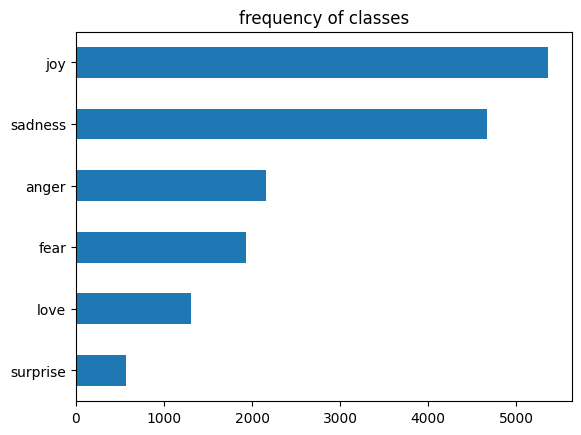

In [43]:
df.label_name.value_counts(ascending=True).plot.barh()
plt.title('frequency of classes')
plt.show()

how long are our tweets?

In [44]:
#create a col words per tweet
df['words_per_tweet'] = df['text'].str.split().apply(len)

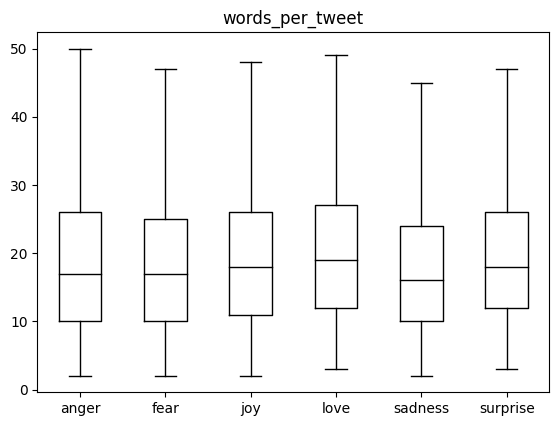

In [47]:
df.boxplot('words_per_tweet', by='label_name', grid=False,
           showfliers=False, color='black')
plt.suptitle("")
plt.xlabel("")
plt.show()

# Tokens

In [48]:
emotions.reset_format()

##Character Tokenization

In [55]:
text = 'Tokenizing text is a core task of NLP.'

In [56]:
tokenized_text= list(text)

In [57]:
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


In [62]:
enumerate(sorted(set(tokenized_text)))

In [58]:
#model expects each character to be converted into integer
token2id = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}

In [59]:
print(token2id)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [64]:
#transform tokenized text to a list of integers
input_ids = [token2id[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [66]:
#transform unique numerical identifier to a 2D tensor of one-hot vectors (use Pytorch)
import torch
import torch.nn.functional as F


In [68]:
#convert input_ids to tensor
input_ids = torch.tensor(input_ids)

In [70]:
one_hot_encodings = F.one_hot(input_ids,num_classes=len(token2id))
one_hot_encodings.shape
#for each of the 38 input tokens we now have one-hot vector with 20 dimensions.
#never forget to set num_classes= !!

torch.Size([38, 20])

In [73]:
#check if a 1 appears the location indicated by input_id[0]
print(f"token: {tokenized_text[0]}")
print(f"tensor index: {input_ids[0]}")
print(f"one_hot_: {one_hot_encodings[0]}")

token: T
tensor index: 5
one_hot_: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


##Word Tokenization

In [74]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


In [75]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{'NLP.': 0, 'Tokenizing': 1, 'a': 2, 'core': 3, 'is': 4, 'of': 5, 'task': 6, 'text': 7}


In [84]:
#punctuation and stem are not recognised, therefore:
import string
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [85]:
# Tokenize the text
tokenized_text = word_tokenize(text)

# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatize and remove punctuation
lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokenized_text if token not in string.punctuation]

print(lemmatized_tokens)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP']


In [86]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(lemmatized_tokens)))}
print(token2idx)

{'NLP': 0, 'Tokenizing': 1, 'a': 2, 'core': 3, 'is': 4, 'of': 5, 'task': 6, 'text': 7}


In [88]:
#transform tokenized text to a list of integers
input_ids = [token2idx[token] for token in lemmatized_tokens]
print(input_ids)

[1, 7, 4, 2, 3, 6, 5, 0]


In [89]:
#convert input_ids to tensor
input_ids = torch.tensor(input_ids)

In [90]:
one_hot_encodings = F.one_hot(input_ids,num_classes=len(token2idx))
one_hot_encodings.shape
#for each of the 38 input tokens we now have one-hot vector with 20 dimensions.
#never forget to set num_classes= !!

torch.Size([8, 8])

In [91]:
#check if a 1 appears the location indicated by input_ids[0]
print(f"token: {lemmatized_tokens[0]}")
print(f"tensor index: {input_ids[0]}")
print(f"one_hot_: {one_hot_encodings[0]}")

token: Tokenizing
tensor index: 1
one_hot_: tensor([0, 1, 0, 0, 0, 0, 0, 0])


## Subword Tokenization